# Exploring the Maraston grids

In this notebook we will explore the Maraston grids and recreate plots from the paper Newman et al. 2024, "Cloudy-Maraston: Integrating nebular line and continuum emission with the M13 stellar population synthesis models". 

In [18]:
# First import the relevant modules, including synthesizer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from synthesizer.grid import Grid
from matplotlib.lines import Line2D
import cmasher as cmr 

# and set up plotting 

plt.rcParams['figure.dpi'] = 200
mpl.rcParams.update({'font.size': 12})
cmap = cmr.bubblegum

## Figure 1: Let's see what our Maraston model looks like!

In [8]:
#Load the grid into synthesizer

grid_dir = '../grids'
grid_name = 'maraston13_kroupa-max_age:7.0_cloudy-c23.01-sps'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=True)

print(grid)

+------------------------------------------------------------------------------------------------+
|                                              GRID                                              |
+-----------------------------+------------------------------------------------------------------+
| Attribute                   | Value                                                            |
+-----------------------------+------------------------------------------------------------------+
| grid_dir                    | '../grids'                                                       |
+-----------------------------+------------------------------------------------------------------+
| grid_name                   | 'maraston13_kroupa-max_age:7.0_cloudy-c23.01-sps'                |
+-----------------------------+------------------------------------------------------------------+
| grid_ext                    | 'hdf5'                                                           |
+---------

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Text(0.5, 0, '$\\rm \\log_{10}(age/yr)$')

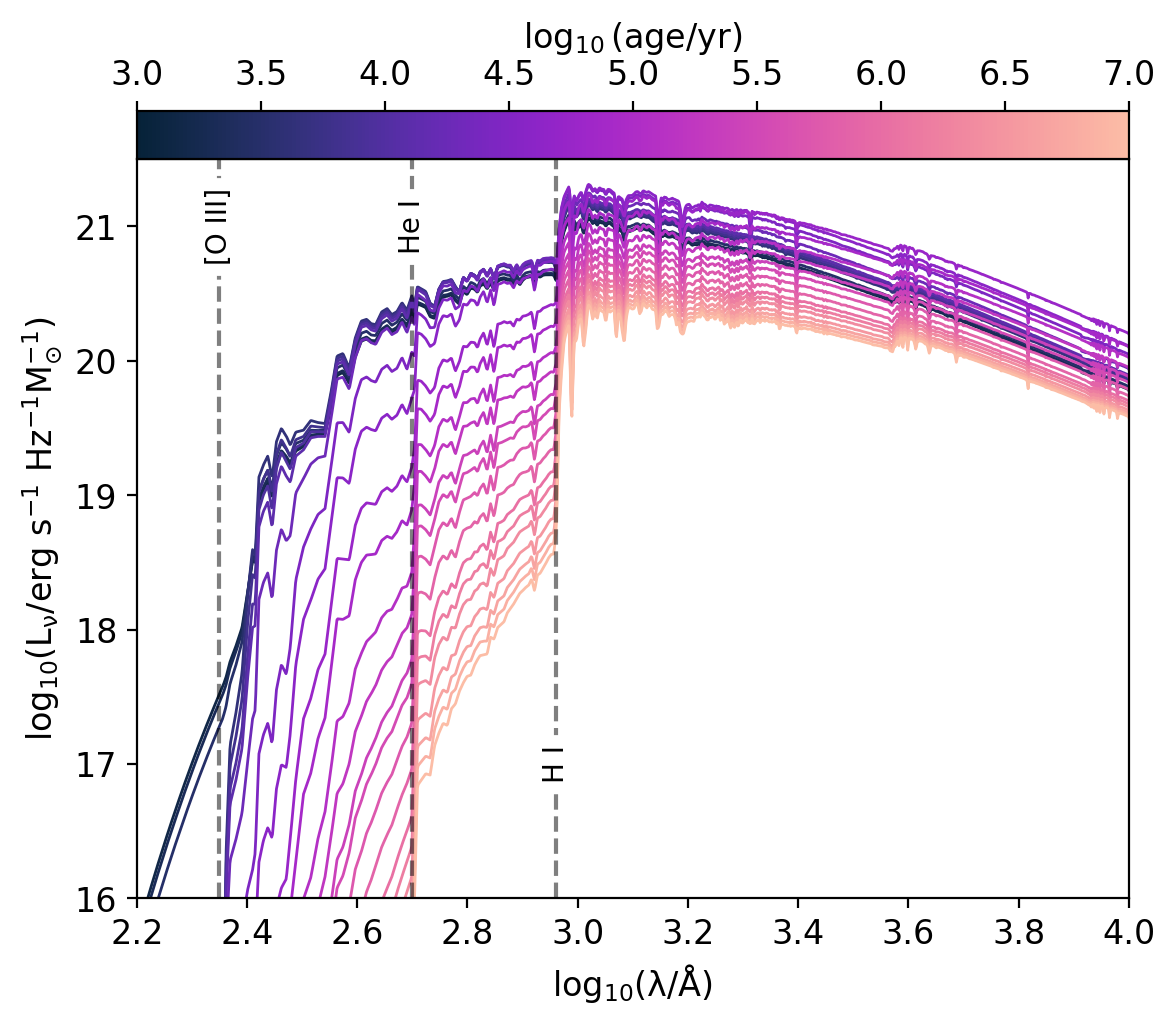

In [19]:
#Plot the spectra at the location of a single metallicity

mpl.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=min(log10ages), vmax=max(log10ages))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

Z = 0.02 
log10ages = grid.log10age

#for each age:
m = 0
for log10age in log10ages: 
    m = m + 1
    grid_point = grid.get_grid_point((log10age,Z))
    #Loop over the available spectra and plot Maraston:
    for spectra_id in ["incident"]:
        # get Sed object
        sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
        ax.plot(np.log10(sed.lam), np.log10(sed.lnu), 
                 lw=1, 
                 label=f'log10age = {round(log10age,1)}',
                 color = cmap(m/len(log10ages)))

plt.xlim(left=2.2, right=4)
plt.ylim(bottom=16, top=21.5)
plt.title(f'Z={Z}')
plt.xlabel(r'$\rm log_{10}(\lambda/\AA)$')
plt.ylabel(r'$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$')

# Show ionisation energies
plt.axvline(x=2.96, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # H I
plt.axvline(x=2.70, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # He I
plt.axvline(x=2.35, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # [O III]

plt.text(x=2.96, y=17, s='H I', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # H I
plt.text(x=2.70, y=21, s='He I', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # He I
plt.text(x=2.35, y=21, s='[O III]', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # [O III]

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"$\rm \log_{10}(age/yr)$")

## Figure 2: Now lets compare the effect of changing the IMF

In [16]:
# Load the necessary grids into synthesizer

grid_dir = '../grids'

grid_name = 'maraston13_kroupa-max_age:7.0'
grid_k = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

grid_name = 'maraston13_salpeter-max_age:7.0'
grid_s = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

Text(0.5, 0, 'Metallicity, Z')

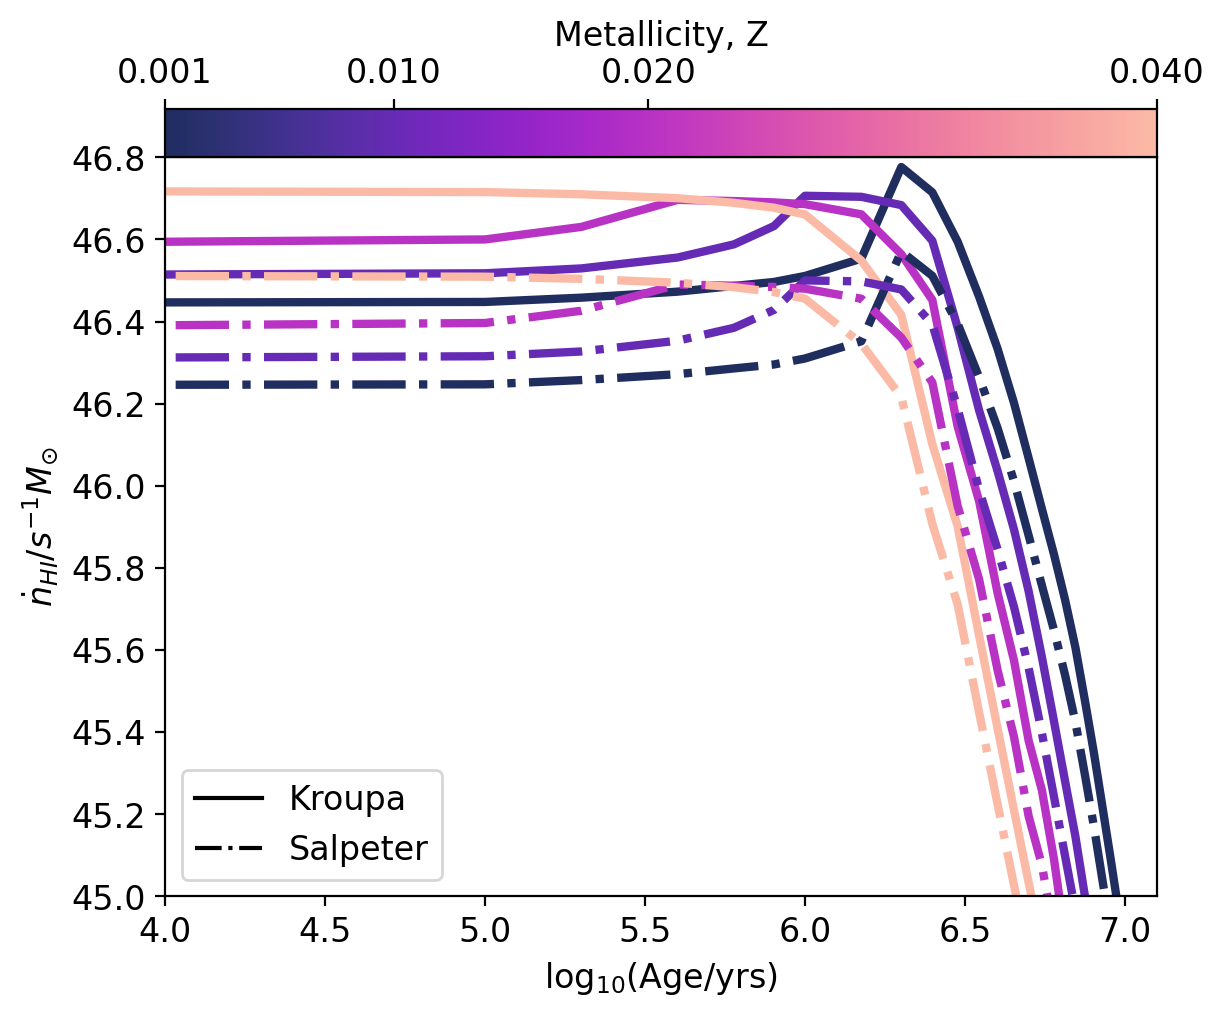

In [21]:
# and plot the differences!

fig, ax = plt.subplots(figsize=(6.4, 4.8))
cmap = cmr.get_sub_cmap('cmr.bubblegum', 0.1, 0.99)
norm = mpl.colors.Normalize(vmin=min(metallicities), vmax=max(metallicities))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

grids = [grid_k, grid_s]
imfs = ['Kroupa', 'Salpeter']

spectra_id = "incident"

Q = grid_k.log10_specific_ionising_lum['HI'] # for all Z
Q_k = Q.T # (4, 67)
for iZ, Z in enumerate(grid_k.metallicity):
    plt.plot(grid_k.log10age, Q_k[iZ,:], color = cmap(norm(Z)), lw=3, ls='-')

Q = grid_s.log10_specific_ionising_lum['HI'] # for all Z
Q_s = Q.T # (4, 67)
for iZ, Z in enumerate(grid_s.metallicity):
    plt.plot(grid_s.log10age, Q_s[iZ,:], color = cmap(norm(Z)), lw=3, ls='-.')

plt.xlabel('log$_{10}$(Age/yrs)')
plt.ylabel(r'$\dot{n}_{HI}/s^{-1}M_{\odot}$')
plt.ylim(bottom=45, top=46.8)
plt.xlim(left=4, right=7.1)

# Create legend
legend_elements = [Line2D([0, 1], [0, 1], linestyle='-', color='black', label='Kroupa'),
                   Line2D([0, 1], [0, 1], linestyle='-.', color='black', label='Salpeter')
]
plt.legend(handles=legend_elements, loc='lower left')

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks(grid_s.metallicity)
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"Metallicity, Z")

## Figure 3: Plot the emission line components

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(3000.0, 10000.0)

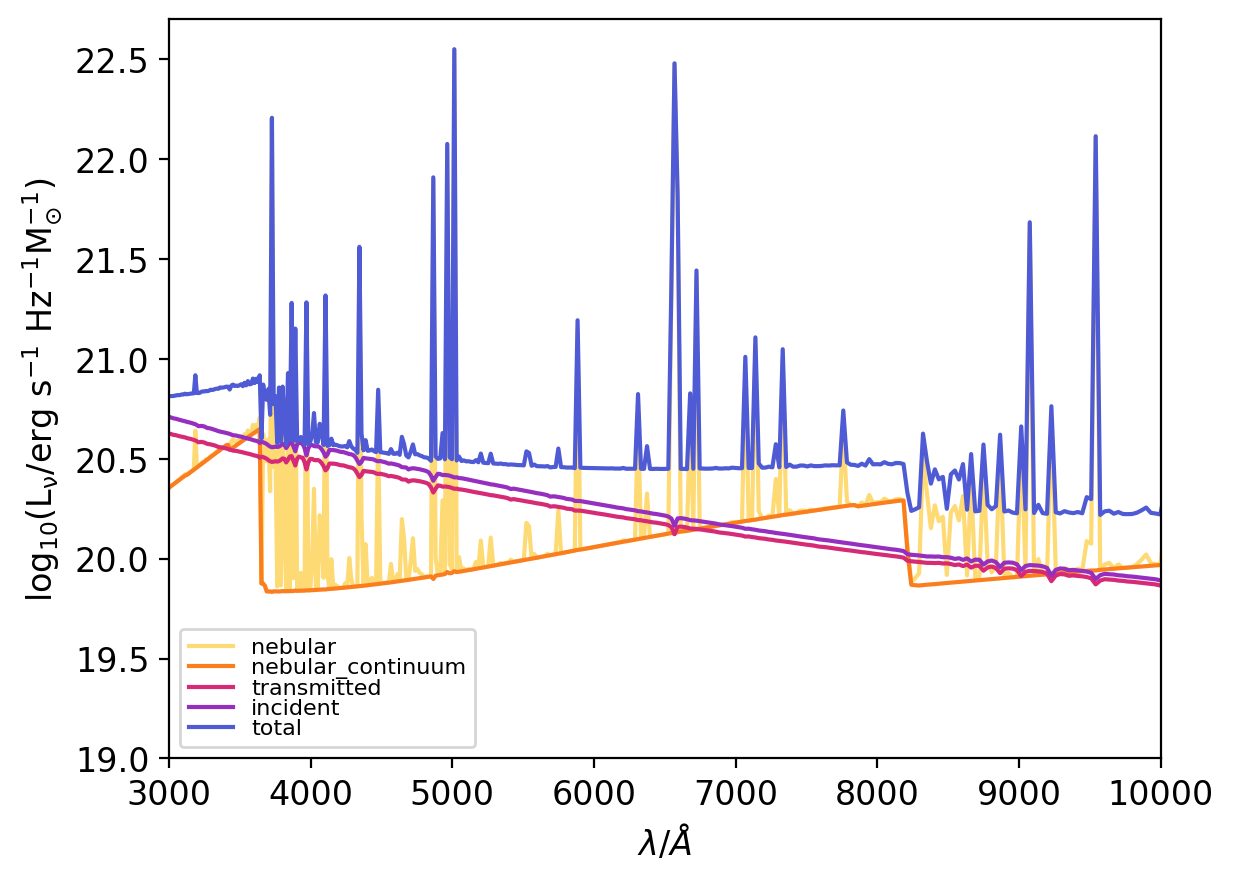

In [23]:
log10age = 6
Z = 0.02
grid_point = grid.get_grid_point((log10age, Z))

fig = plt.figure(figsize=(6.4, 4.8))

spectra_ids = ["nebular", "nebular_continuum", "transmitted", "incident", "total" ]
colors = ["#feda75", "#fa7e1e", "#d62976", "#962fbf", "#4f5bd5"]

for i, spectra_id in enumerate(spectra_ids):
    # get Sed object
    sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
    plt.plot(
        sed.lam, np.log10(sed.lnu), lw=1.5, label=spectra_id, color=colors[i]
    )

plt.legend(fontsize=8, labelspacing=0.0)
plt.xlabel(r"$\lambda/\AA$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")

plt.ylim(bottom=19, top=22.7)
plt.xlim(left=3000, right=10000)